# Decision Trees for merged_all.csv  
Kevin Cotellesso  
Written 1-29-2025  
  
This file contains decision trees trained on merged_all.csv, in an attempt to determine which S.M.A.R.T attributes may be important for predicting failure.  
  


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
## Import dataset
df_og = pd.read_csv('Merged_data/merged_all.csv', low_memory=False)

In [4]:
## Data Preprocessing
# 1) Remove non-raw columns from the data.
df = df_og.drop([col for col in df_og.columns if col.endswith('_normalized')], axis=1)

# 2) Convert SMART attribute columns to integers where applicable
columns_as_ints = []
for column in df.columns:
    if '_' in column: # e.g., 'smart_5_normalized' or 'serial_number'
        parts = column.split('_')
        if parts[1].isdigit(): # e.g., 'smart_5_normalized'
            columns_as_ints.append(int(parts[1]))
        else: # e.g., 'serial_number'
            columns_as_ints.append(column)
    else: # e.g., 'date', 'model'
        columns_as_ints.append(column)

df.columns = columns_as_ints

In [ ]:
## Pare down dataset to specific SMART attributes based on presence across models
attributes = [9, 194, 12, 1, 5, 199, 198, 197, 3, 7, 4, 192, 10, 193] # See analyze_SMART_presence_kevin.ipynb for how these were chosen
columns_to_keep = ['model', 'date', 'capacity_bytes'] + attributes + ['failure']
df_reduced = df[columns_to_keep]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76542 entries, 0 to 76541
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model           76542 non-null  object 
 1   date            76542 non-null  object 
 2   capacity_bytes  76542 non-null  float64
 3   9               76382 non-null  float64
 4   194             76160 non-null  float64
 5   12              75449 non-null  float64
 6   1               75289 non-null  float64
 7   5               74405 non-null  float64
 8   199             73472 non-null  float64
 9   198             72383 non-null  float64
 10  197             71541 non-null  float64
 11  3               70503 non-null  float64
 12  7               70503 non-null  float64
 13  4               70503 non-null  float64
 14  192             70498 non-null  float64
 15  10              70461 non-null  float64
 16  193             66695 non-null  float64
 17  failure         76542 non-null 

In [6]:
## Calculate baseline
failure_counts = df_reduced['failure'].value_counts(normalize=True)
print("Failure distribution in reduced dataset:")
print(failure_counts)

Failure distribution in reduced dataset:
failure
0    0.606412
1    0.393588
Name: proportion, dtype: float64


In [ ]:
## Set up tree, CV search, and training data
# Tree and grid search setup
dtree = DecisionTreeClassifier()
param_grid = {'max_depth': range(1, 11)}
grid_search = GridSearchCV(dtree, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=5)
# Training data setup
X = df_reduced.drop(['model', 'date', 'failure'], axis=1) # Note that we keep capacity_bytes
X.columns = X.columns.astype(str)  # Convert columns to strings for sklearn
# All these are float64 so no need to one hot encode.
y = df_reduced['failure']

In [ ]:
## Fit tree with grid search
grid_search.fit(X, y)

,estimator,DecisionTreeClassifier()
,param_grid,"{'max_depth': range(1, 11)}"
,scoring,'accuracy'
,n_jobs,16
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,criterion,'gini'


Best max_depth: 10
Best cross-validated accuracy: 0.8652641637489389


<Axes: title={'center': 'Top 10 Feature Importances'}, ylabel='Feature'>

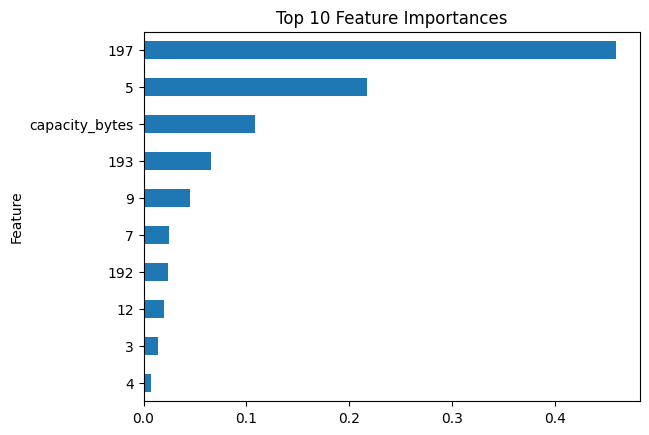

In [22]:
## Best hyperparameters and results
print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best cross-validated accuracy:", grid_search.best_score_)
best_dtree = grid_search.best_estimator_
feature_importances = best_dtree.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)
importance_df.tail(10).plot.barh(x='Feature', y='Importance', legend=False, title='Top 10 Feature Importances')